In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN

## Generate data

In [42]:
# run lorenz63 system
my_lorenz63 = Lorenz63(beta=8/3, rho=28, sigma=10, t_lyap=0.9**(-1))

dt = 0.01

transient_time = 20
washout_time = 1
train_time = 100
val_time = 10
test_time = 500

simulation_time = transient_time+3*washout_time+train_time+val_time+test_time

t = np.arange(0,simulation_time+dt,dt)
# u0 = np.array([ 7.432487609628195, 10.02071718705213, 29.62297428638419]) 
u0 = np.array([0.0, 1.0, 1.0]) 
u = solve_ode.integrate(my_lorenz63, u0, t, integrator='rk4')

Running solver.


In [43]:
# separate into washout and loops
network_dt = dt
loop_times = [train_time,val_time,test_time]
loop_names = ['train','val','test']

u, t = pp.discard_transient(u, t, transient_time)

N_washout, *N_loops = [
    pp.get_steps(t, network_dt) for t in [washout_time, *loop_times]
]
start_idx = 0
data = {}
for loop_idx, N_loop in enumerate(N_loops):
    # get washout and loop data
    u_washout, u_loop, y_loop, t_loop = pp.create_input_output(
        u[start_idx:], u[start_idx:], t[start_idx:], N_washout, N_loop + 1
    )
    if loop_names is not None:
        loop_name = loop_names[loop_idx]
    else:
        loop_name = f"loop_{loop_idx}"

    data[loop_name] = {
        "u_washout": u_washout,
        "u": u_loop,
        "y": y_loop,
        "t": t_loop,
    }
    start_idx += N_washout + N_loop

In [37]:
# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['spectral_radius','input_scaling','tikhonov']

# range for hyperparameters 
spec_in     = 0.1
spec_end    = 1.0
in_scal_in  = 0.1
in_scal_end = 5.0
leak_in     = 0.1    
leak_end    = 1.0
tikh_in = 1e-12
tikh_end = 1e-6
grid_range = [[spec_in, spec_end],
              [in_scal_in, in_scal_end],
            #   [leak_in, leak_end],
              [tikh_in, tikh_end]]

# scales, uniform or log10
hyp_param_scales = ['uniform','log10','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])

fold_time = 0.5*my_lorenz63.t_lyap
N_val = pp.get_steps(fold_time, network_dt)
N_val = 50
reservoir_size = 100
connectivity = 3
ESN_dict = {'reservoir_size': reservoir_size, 
            'dimension' : my_lorenz63.N_dim, 
            'reservoir_connectivity' : connectivity,
            'reservoir_weights_mode': "erdos_renyi1",
            'tikhonov': 1e-3,
            'input_bias' : np.array([1.0]),
            'output_bias' : np.array([1.0]),
            }
min_dict = validate(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 20, n_initial_points = 10,
    ESN_dict = ESN_dict, ESN_type = "standard",
    U_washout_train = data["train"]["u_washout"],
    U_train = data["train"]["u"],
    U_val = data["val"]["u"],
    Y_train = data["train"]["y"],
    Y_val = data["val"]["y"],
    n_folds=2,
    n_realisations=5,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    random_seed=20,
    n_grid = None)

--NEW RUN-- 1
Realisation: 0
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  12.517854815319867
Fold: 1 , fold error:  25.86099118694796
Val regime error: 19.189423001133914
Realisation error: 19.189423001133914


Realisation: 1
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  6.099062984504166
Fold: 1 , fold error:  6.974549784145599
Val regime error: 6.5368063843248825
Realisation error: 6.5368063843248825


Realisation: 2
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  23681.69174346939
Fold: 1 , fold error:  9.891837288688691
Val regime error: 11845.791790379039
Realisation error: 11845.791790379039


Realisation: 3
spectral_radius 0.8986705348487375
input_scaling 4.18328857077979
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  5832.302294390925
Fold: 1 , fold erro

c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.53623e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  76982.9851305065
Fold: 1 , fold error:  4.353855272856521
Val regime error: 38493.669492889676
Realisation error: 38493.669492889676


Realisation: 1
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01241e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  17.389097259217586
Fold: 1 , fold error:  79427.15337424008
Val regime error: 39722.27123574965
Realisation error: 39722.27123574965


Realisation: 2
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.5048e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  65864.9706324446
Fold: 1 , fold error:  4.216975979507609
Val regime error: 32934.593804212054
Realisation error: 32934.593804212054


Realisation: 3
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.0007e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  22.22679237263192
Fold: 1 , fold error:  73004.64238357983
Val regime error: 36513.43458797623
Realisation error: 36513.43458797623


Realisation: 4
spectral_radius 0.5296489325560247
input_scaling 2.9624550156592733
tikhonov 1e-10




c:\Users\egeoz\anaconda3\envs\esn_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.18007e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  15380255.92056676
Fold: 1 , fold error:  15703979.736374544
Val regime error: 15542117.828470651
Realisation error: 15542117.828470651


Run 5 error: 3137956.359518296


--NEW RUN-- 6
Realisation: 0
spectral_radius 0.9158805549519091
input_scaling 0.10053776822301841
tikhonov 1e-09


Val regime: 0
Fold: 0 , fold error:  0.31872560279990597
Fold: 1 , fold error:  0.3609281741540117
Val regime error: 0.33982688847695885
Realisation error: 0.33982688847695885


Realisation: 1
spectral_radius 0.9158805549519091
input_scaling 0.10053776822301841
tikhonov 1e-09


Val regime: 0
Fold: 0 , fold error:  5.844908611981713
Fold: 1 , fold error:  12.904687883444995
Val regime error: 9.374798247713354
Realisation error: 9.374798247713354


Realisation: 2
spectral_radius 0.9158805549519091
input_scaling 0.10053776822301841
tikhonov 1e-09


Val regime: 0
Fold: 0 , fold error:  0.0278863358883596
Fold: 1 , fold error:  0.012767938398943725
Val regime error: 0.020327

In [38]:
res_idx = 0
my_ESN = ESN(**ESN_dict)
hyp_params = [min_dict[hyp_param_name][res_idx] for hyp_param_name in hyp_param_names]
hyp_param_scales = ['uniform']*len(hyp_param_names)
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

my_ESN.train(data["train"]["u_washout"], data["train"]["u"], data["train"]["y"])

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Input weights are rescaled with the new input scaling.
Reservoir weights are rescaled with the new spectral radius.


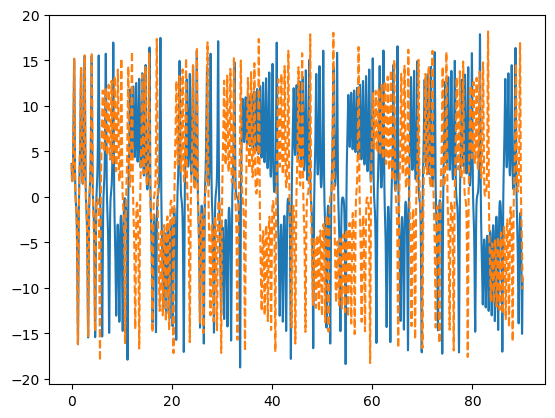

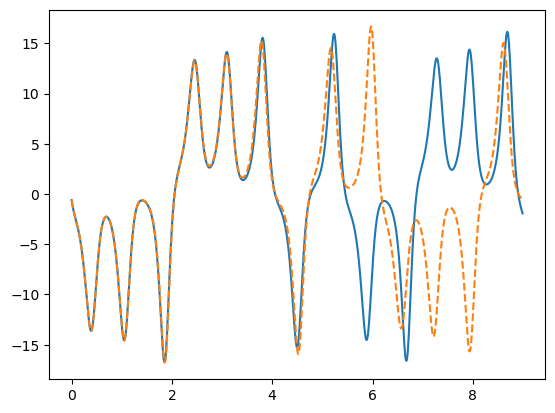

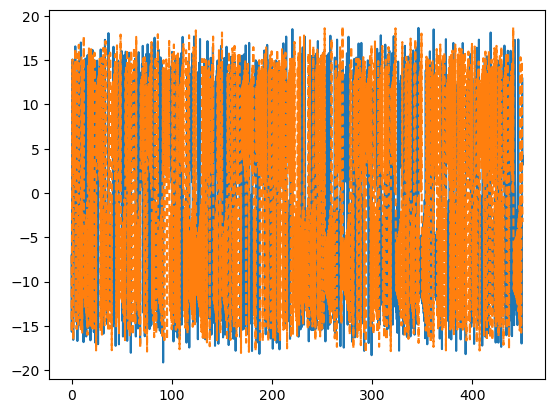

In [44]:
pred = {}
for loop_name in loop_names:
    pred[loop_name] = {}
    pred[loop_name]["X"], pred[loop_name]["y"] = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"],
                                                    N_t=len(data[loop_name]["u"]),)
    plt.figure()
    plt.plot((data[loop_name]["t"]-data[loop_name]["t"][0])/my_lorenz63.t_lyap,data[loop_name]["y"][:,0])
    plt.plot((data[loop_name]["t"]-data[loop_name]["t"][0])/my_lorenz63.t_lyap,pred[loop_name]["y"][1:,0],'--')


In [45]:
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_lorenz63,
                                 sys_type='continuous',
                                 X=data["test"]["u"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=dt,
                                 target_dim=None,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

[ 9.00508937e-01 -2.07512880e-03 -1.45649987e+01]


In [46]:
LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='ESN',
                                 X=pred["test"]["X"],
                                 t=data["test"]["t"],
                                 transient_time=transient_time,
                                 dt=dt,
                                 target_dim=my_lorenz63.N_dim,
                                 norm_step=1)
LEs_target = LEs[-1]
print(LEs_target)
CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

[ 9.08731955e-01 -1.80437125e-03 -1.72292874e+01]
